# Daily Forecasting

# Imports

In [86]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Loading & Pre-processing Data

In [87]:
import io
df = pd.read_csv('AMZN_Daily_10year.csv')

In [88]:
def load_data(df, start, end):
    """
    Load data for the date range.

    :param start: The starting date for the data range (str or datetime)
    :param end: The ending date for the data range (str or datetime)
    :return: A dataframe containing the relevant stock data (pandas.DataFrame)
    """
    dataframe = df.copy()
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    return dataframe

In [89]:
START_DATE = dt.datetime(2013,11,1)
END_DATE = dt.datetime(2021,11,1)

START_DATE_TEST = END_DATE

In [90]:
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-11-04,18.006001,18.049999,17.719999,17.937000,17.937000,38768000
1,2013-11-05,17.839001,18.008499,17.742001,17.944500,17.944500,40142000
2,2013-11-06,18.022499,18.143499,17.725000,17.809000,17.809000,45646000
3,2013-11-07,17.792999,17.895000,17.094000,17.177999,17.177999,84926000
4,2013-11-08,17.297501,17.552500,17.202000,17.515499,17.515499,53138000
...,...,...,...,...,...,...,...
2511,2023-10-26,120.629997,121.639999,118.349998,119.570000,119.570000,100419500
2512,2023-10-27,126.199997,130.020004,125.519997,127.739998,127.739998,125309300
2513,2023-10-30,129.720001,133.000000,128.559998,132.710007,132.710007,72485500
2514,2023-10-31,132.750000,133.570007,131.710007,133.089996,133.089996,51589400


In [91]:
train_data = load_data(df,
                 start = START_DATE,
                 end = END_DATE)

In [92]:
train_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-11-04,18.006001,18.049999,17.719999,17.937000,17.937000,38768000
1,2013-11-05,17.839001,18.008499,17.742001,17.944500,17.944500,40142000
2,2013-11-06,18.022499,18.143499,17.725000,17.809000,17.809000,45646000
3,2013-11-07,17.792999,17.895000,17.094000,17.177999,17.177999,84926000
4,2013-11-08,17.297501,17.552500,17.202000,17.515499,17.515499,53138000
...,...,...,...,...,...,...,...
2007,2021-10-25,166.750000,167.389999,164.884995,166.018494,166.018494,44520000
2008,2021-10-26,167.475494,170.806000,167.199005,168.803497,168.803497,53966000
2009,2021-10-27,169.399994,171.850006,168.572495,169.624496,169.624496,54044000
2010,2021-10-28,170.104996,173.949997,169.300003,172.328506,172.328506,114174000


In [93]:
# Normalize Data
scaler = MinMaxScaler(feature_range=(-1,1)) # Why do we need to do this? # should it be -1, 1
scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))

In [95]:
# Set the number of days used for prediction
prediction_days = 35

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_days:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# Think of this as a list of 2D arrays it should have dimensions (150,1,2366)

# LSTM Model

In [97]:
def LSTM_model():
    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 70 units, input shape, and return sequences
    model.add(LSTM(units=64, recurrent_dropout=0.2, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # Add dropout to prevent overfitting
    #model.add(Dropout(0.2))

     # Add a second LSTM layer with 70 units and return sequences
    model.add(LSTM(units=64, recurrent_dropout=0.2, return_sequences=True))
    # Add dropout to prevent overfitting
    #model.add(Dropout(0.2))

    # Add a third LSTM layer with 70 units
    model.add(LSTM(units=64, recurrent_dropout=0.2))
    # Add dropout to prevent overfitting
    #model.add(Dropout(0.2))
    
    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

In [98]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 35, 64)            16896     
                                                                 
 lstm_19 (LSTM)              (None, 35, 64)            33024     
                                                                 
 lstm_20 (LSTM)              (None, 64)                33024     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83009 (324.25 KB)
Trainable params: 83009 (324.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [99]:
model.fit(
    x_train,
    y_train,
    epochs=25,
    batch_size = 32,
)

Epoch 1/25
62/62 [==============================] - 6s 41ms/step - loss: 0.0288
Epoch 2/25
62/62 [==============================] - 3s 44ms/step - loss: 0.0027
Epoch 3/25
62/62 [==============================] - 3s 48ms/step - loss: 0.0025
Epoch 4/25
62/62 [==============================] - 3s 47ms/step - loss: 0.0025
Epoch 5/25
62/62 [==============================] - 3s 47ms/step - loss: 0.0024
Epoch 6/25
62/62 [==============================] - 3s 47ms/step - loss: 0.0023
Epoch 7/25
62/62 [==============================] - 3s 47ms/step - loss: 0.0021
Epoch 8/25
62/62 [==============================] - 3s 48ms/step - loss: 0.0021
Epoch 9/25
62/62 [==============================] - 3s 47ms/step - loss: 0.0020
Epoch 10/25
62/62 [==============================] - 3s 47ms/step - loss: 0.0019
Epoch 11/25
62/62 [==============================] - 3s 51ms/step - loss: 0.0017
Epoch 12/25
62/62 [==============================] - 3s 48ms/step - loss: 0.0017
Epoch 13/25
62/62 [==================

# Inference

In [100]:
# Load test data for the specified company and date range
test_data = load_data(
    df,
    start=START_DATE_TEST,
    end=dt.datetime.now()
)

# Extract the actual closing prices from the test data
actual_prices = test_data['Close'].values

# Concatenate the training and test data along the 'Close' column
total_dataset = pd.concat((train_data['Close'], test_data['Close']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
#model inputs start x prediction days before the first day we want to predict

# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler.transform(model_inputs)

In [101]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

16/16 [==============================] - 0s 7ms/step


In [107]:
predicted_prices.shape

(503, 1)

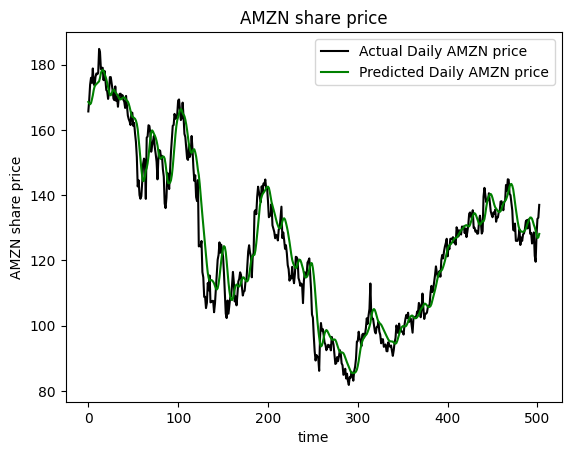

In [102]:
# Plot the actual prices using a black line
plt.plot(actual_prices, color='black', label=f"Actual Daily AMZN price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label=f"Predicted Daily AMZN price")

# Set the title of the plot using the company name
plt.title(f"AMZN share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"AMZN share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

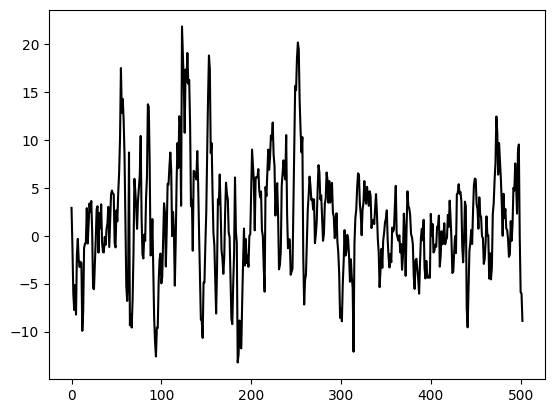

In [112]:
plt.plot(predicted_prices.flatten() - actual_prices, color='black', label=f"Actual Daily AMZN price")
plt.show()

In [111]:
differences = predicted_prices.flatten() - actual_prices
print(differences[:10])

[ 2.91201777 -1.05900579 -6.02142324 -7.7435909  -5.13859545 -8.22904976
 -1.91126986 -0.32495117 -2.49845854 -3.26165813]


In [103]:
# Extract the last 'prediction_days' values from the model inputs to make a prediction for the future
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]

# Convert the real_data list to a numpy array
real_data = np.array(real_data)

# Reshape real_data to a 3D array with the appropriate dimensions for the LSTM model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Generate a prediction using the LSTM model with the real_data input
prediction = model.predict(real_data) #prediction for 10/30

# Invert the scaling applied to the prediction to obtain the actual value
prediction = scaler.inverse_transform(prediction)

# Print the prediction result to the console
print(f"Prediction: {prediction[0][0]}")

1/1 [==============================] - 0s 311ms/step
Prediction: 129.92318725585938


# Evaluation

In [105]:
predicted_prices1D = predicted_prices.flatten()

# Average percent error

percent_error = (np.abs(actual_prices - predicted_prices1D) / actual_prices) * 100
avg_percent_error = np.sum(percent_error) / len(percent_error)
print("Avergae percent error: ", avg_percent_error)

# RMSE
# Step 1: Calculate the squared differences
squared_diff = (predicted_prices1D - actual_prices) ** 2

# Step 2: Compute the mean of squared differences
mean_squared_diff = squared_diff.mean()

# Step 3: Take the square root to get RMSE
rmse = np.sqrt(mean_squared_diff)

print("Root Mean Square Error (RMSE):", rmse)


# Out of Sample R square
# Calculate the mean of the actual target values
actual_mean = np.mean(actual_prices) # compare to rolling mean of window

# Calculate SST, SSR, and SSE
SST = np.sum((actual_prices - actual_mean) ** 2)
SSE = np.sum((actual_prices - predicted_prices1D) ** 2)

# Calculate out-of-sample R-squared
out_of_sample_r_squared = 1 - (SSE / SST)

print("Out-of-sample R-squared:", out_of_sample_r_squared)

Avergae percent error:  3.668391134546741
Root Mean Square Error (RMSE): 5.940858317381005
Out-of-sample R-squared: 0.943574812431364


In [ ]:
#using the same x_test that was input for the LSTM
#using prediction_days = 150

# Initialize an empty list to store moving averages
moving_averages = np.empty((len(predicted_prices1D), ), dtype=np.float64)

# Loop through x_test to consider
# every window of size prediction_days
for i in range(len(x_test)):

    # get the current window
    window = x_test[i].flatten()

    # Calculate the average of current window
    window_average = np.mean(window)

    # Store the average of current
    # window in moving average list
    moving_averages[i] = window_average

rolling_average_prediction = scaler.inverse_transform(moving_averages.reshape(-1, 1))

# Weekly Forecasting

Loading & Pre-processing data

In [44]:
df = pd.read_csv('AMZN_Weekly.csv')

START_DATE = dt.datetime(2013,10,28)
END_DATE = dt.datetime(2020,10,29)

START_DATE_TEST = END_DATE

In [45]:
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-10-28,17.948000,18.299999,17.805000,17.950001,17.950001,249708000
1,2013-11-04,18.006001,18.143499,17.094000,17.515499,17.515499,262620000
2,2013-11-11,17.529499,18.645000,17.284000,18.458500,18.458500,320590000
3,2013-11-18,18.514000,18.725000,18.022499,18.615499,18.615499,226876000
4,2013-11-25,18.691000,19.705000,18.659000,19.681000,19.681000,207448000
...,...,...,...,...,...,...,...
517,2023-09-25,129.360001,131.779999,123.040001,127.120003,127.120003,302552000
518,2023-10-02,127.279999,130.470001,124.129997,127.959999,127.959999,230255100
519,2023-10-09,126.220001,134.479996,124.760002,129.789993,129.789993,223009300
520,2023-10-16,130.690002,133.070007,124.970001,125.169998,125.169998,252181700


In [46]:
#Load training data - 7 year window
train_data = load_data(df,
                 start = START_DATE,
                 end = END_DATE)

train_data

,Date,Open,High,Low,Close,Adj Close,Volume
1,2013-11-04,18.006001,18.143499,17.094000,17.515499,17.515499,262620000
2,2013-11-11,17.529499,18.645000,17.284000,18.458500,18.458500,320590000
3,2013-11-18,18.514000,18.725000,18.022499,18.615499,18.615499,226876000
4,2013-11-25,18.691000,19.705000,18.659000,19.681000,19.681000,207448000
5,2013-12-02,19.950001,19.950001,19.068501,19.347500,19.347500,293268000
...,...,...,...,...,...,...,...
361,2020-09-28,157.442505,161.199997,155.858505,156.250000,156.250000,464022000
362,2020-10-05,157.292007,164.449493,154.500000,164.332504,164.332504,425072000
363,2020-10-12,167.496994,174.811996,158.000000,163.635498,163.635498,632388000
364,2020-10-19,164.980499,166.449997,156.097000,160.220001,160.220001,440094000


In [47]:
# Normalize Data
scaler = MinMaxScaler(feature_range=(0,1)) # Why do we need to do this?
scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))

In [48]:
# Set the number of weeks used for prediction
prediction_weeks = 24

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data
for x in range(prediction_weeks, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_weeks:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# Think of this as a list of 2D arrays 

In [52]:
def LSTM_model():
    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 150 units, input shape, and return sequences
    model.add(LSTM(units=150, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

     # Add a second LSTM layer with 150 units and return sequences
    model.add(LSTM(units=150, return_sequences=True))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a third LSTM layer with 150 units
    model.add(LSTM(units=150))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))
    
    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

In [53]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 24, 150)           91200     
                                                                 
 dropout_30 (Dropout)        (None, 24, 150)           0         
                                                                 
 lstm_34 (LSTM)              (None, 24, 150)           180600    
                                                                 
 dropout_31 (Dropout)        (None, 24, 150)           0         
                                                                 
 lstm_35 (LSTM)              (None, 150)               180600    
                                                                 
 dropout_32 (Dropout)        (None, 150)               0         
                                                                 
 dense_7 (Dense)             (None, 1)               

In [54]:
model.fit(
    x_train,
    y_train,
    epochs=25,
    batch_size = 32,
)

Epoch 1/25
11/11 [==============================] - 3s 46ms/step - loss: 0.0367
Epoch 2/25
11/11 [==============================] - 1s 54ms/step - loss: 0.0074
Epoch 3/25
11/11 [==============================] - 1s 53ms/step - loss: 0.0045
Epoch 4/25
11/11 [==============================] - 1s 56ms/step - loss: 0.0038
Epoch 5/25
11/11 [==============================] - 1s 50ms/step - loss: 0.0033
Epoch 6/25
11/11 [==============================] - 1s 52ms/step - loss: 0.0034
Epoch 7/25
11/11 [==============================] - 1s 50ms/step - loss: 0.0026
Epoch 8/25
11/11 [==============================] - 1s 51ms/step - loss: 0.0022
Epoch 9/25
11/11 [==============================] - 1s 56ms/step - loss: 0.0026
Epoch 10/25
11/11 [==============================] - 1s 61ms/step - loss: 0.0023
Epoch 11/25
11/11 [==============================] - 1s 57ms/step - loss: 0.0027
Epoch 12/25
11/11 [==============================] - 1s 56ms/step - loss: 0.0033
Epoch 13/25
11/11 [==================

Test Against Weekly prices over the past 3 years

In [55]:
# Load test data for the specified company and date range
test_data = load_data(
    df,
    start=START_DATE_TEST,
    end=dt.datetime.now()
)

# Extract the actual closing prices from the test data
actual_prices = test_data['Close'].values

# Concatenate the training and test data along the 'Close' column
total_dataset = pd.concat((train_data['Close'], test_data['Close']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_weeks:].values
#model inputs start x prediction days before the first day we want to predict

# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler.transform(model_inputs)

In [57]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_weeks index
for x in range(prediction_weeks, len(model_inputs)):
    # Append the previous 'prediction_weeks' values to x_test
    x_test.append(model_inputs[x-prediction_weeks:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

5/5 [==============================] - 0s 14ms/step


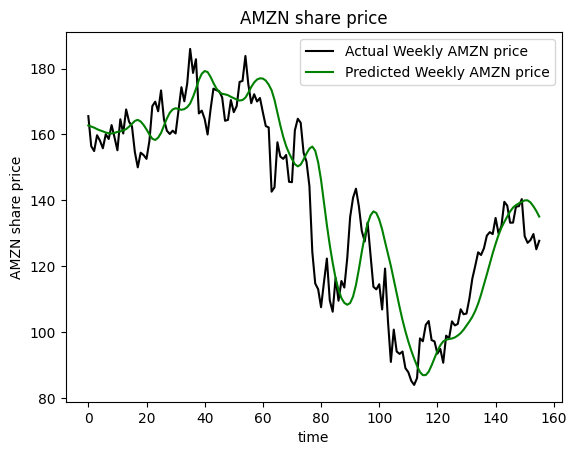

In [58]:
# Plot the actual prices using a black line
plt.plot(actual_prices, color='black', label=f"Actual Weekly AMZN price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label=f"Predicted Weekly AMZN price")

# Set the title of the plot using the company name
plt.title(f"AMZN share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"AMZN share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

In [59]:
# Extract the last 'prediction_days' values from the model inputs to make a prediction for the future
real_data = [model_inputs[len(model_inputs) + 1 - prediction_weeks:len(model_inputs + 1), 0]]

# Convert the real_data list to a numpy array
real_data = np.array(real_data)

# Reshape real_data to a 3D array with the appropriate dimensions for the LSTM model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Generate a prediction using the LSTM model with the real_data input
prediction = model.predict(real_data) #prediction for 10/25

# Invert the scaling applied to the prediction to obtain the actual value
prediction = scaler.inverse_transform(prediction)

# Print the prediction result to the console - Prediction for 11/2
print(f"Prediction: {prediction[0][0]}")

1/1 [==============================] - 0s 480ms/step
Prediction: 133.53839111328125


Test Evaluation

In [60]:
predicted_prices1D = predicted_prices.flatten()

# Average percent error

percent_error = (np.abs(actual_prices - predicted_prices1D) / actual_prices) * 100
avg_percent_error = np.sum(percent_error) / len(percent_error)
print("Avergae percent error: ", avg_percent_error)

# RMSE
# Step 1: Calculate the squared differences
squared_diff = (predicted_prices1D - actual_prices) ** 2

# Step 2: Compute the mean of squared differences
mean_squared_diff = squared_diff.mean()

# Step 3: Take the square root to get RMSE
rmse = np.sqrt(mean_squared_diff)

print("Root Mean Square Error (RMSE):", rmse)


# Out of Sample R square
# Calculate the mean of the actual target values
actual_mean = np.mean(actual_prices)

# Calculate SST, SSR, and SSE
SST = np.sum((actual_prices - actual_mean) ** 2)
SSE = np.sum((actual_prices - predicted_prices1D) ** 2)

# Calculate out-of-sample R-squared
out_of_sample_r_squared = 1 - (SSE / SST)

print("Out-of-sample R-squared:", out_of_sample_r_squared)

Avergae percent error:  7.330200063239234
Root Mean Square Error (RMSE): 12.388689707494217
Out-of-sample R-squared: 0.7993195905335669
